<a href="https://colab.research.google.com/github/mahtabtech/Video-Audio-Fall_detection/blob/main/video_audio_multimodal_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
!pip install av
from torchvision.datasets.video_utils import VideoClips

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
#from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import librosa
from tqdm import tqdm

from IPython.display import Audio
from torchvision.io import read_video

!pip install torch transformers torchaudio

import os
from collections import defaultdict
from io import BytesIO
from tqdm import tqdm
import IPython.display as ipd

!pip install torchmetrics
from torchmetrics import Accuracy
from torchmetrics.classification import BinaryAccuracy


from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
# np.random.seed(2020)
# random.seed(2020)
# torch.manual_seed(2020)
import torch
import torchvision.transforms as transforms
import cv2
from torchvision.io import read_video
from torchvision.transforms import ToPILImage, Resize, ToTensor, Normalize

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Set seed for Python random number generator
random.seed(42)

# Set seed for NumPy random number generator
np.random.seed(42)

# Set seed for PyTorch random number generator
torch.manual_seed(42)

# Check if CUDA is available and set seed for CUDA random number generator
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# **Audio Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# **General Utils and functions for calculating accuracy**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = BinaryAccuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = BinaryAccuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **one of audio files to get info about it**

In [ ]:
Audio('/content/drive/MyDrive/Falldetection/new_shorten_audio/train/audio/video (14).wav')

In [ ]:
#Information about the audio file
metadata = torchaudio.info('/content/drive/MyDrive/Falldetection/new_shorten_audio/train/audio/video (14).wav')
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=88200, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [ ]:
# Loading that one sample or getting waveform and sample rate of that one sample
waveformm, sample_ratee = torchaudio.load('/content/drive/MyDrive/Falldetection/new_shorten_audio/train/audio/video (14).wav')
print(waveformm)   #chon 2 channel dare natije 2 ta satr mide
print(sample_ratee)   #44100
print(waveformm.shape , sample_ratee)   #[2, 637056] yani 2 channel dare va 63 hezar ta frame
#print_stats(waveformm, sample_ratee)

tensor([[-0.0104, -0.0058,  0.0029,  ..., -0.0005, -0.0024, -0.0050],
        [ 0.0064,  0.0097,  0.0167,  ..., -0.0009, -0.0015, -0.0030]])
44100
torch.Size([2, 88200]) 44100


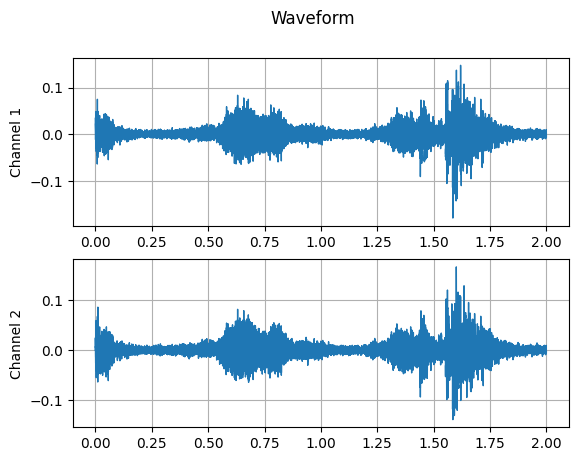

In [ ]:
plot_waveform(waveformm, sample_ratee)

# **Audio custom dataset**

**First step: Converting 2 channels to 1 channel for audio dataset**

In [ ]:
#Converting Stero(2 channels to one channels (mono)) and changing sample rate to 16000 because M5 needs 16000 sample rate

class StereoToMono(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, waveform):
        # Check if the waveform is stereo
        if waveform.shape[0] == 2:
            # Convert stereo waveform to mono by averaging the channels
            waveform_mono = waveform.mean(dim=0, keepdim=True)
        else:
            # If the waveform is already mono, return it unchanged
            waveform_mono = waveform
        return waveform_mono


# Create a transform pipeline with stereo to mono conversion followed by resampling to 16,000 Hz
train_transform = nn.Sequential(
    StereoToMono(),
    T.Resample(orig_freq=44100, new_freq=16000)
)

test_transform = nn.Sequential(
    StereoToMono(),
    T.Resample(orig_freq=44100, new_freq=16000)
)

**Step 2: creating custom dataset**

In [ ]:
class CustomDatasetAudioTrain(Dataset):
    def __init__(self, dataset_path, mode='train', voice_transform=None):
        base_path = os.path.join(dataset_path, mode)
        self.voice_path = os.path.join(base_path, 'audio')
        self.labels = pd.read_csv(os.path.join(base_path, 'labels_train.csv'))
        self.voice_transform = voice_transform

    def __getitem__(self, idx):
        id, label = self.labels.iloc[idx].tolist()
        voice_file = os.path.join(self.voice_path, id+'.wav')

        # load files
        waveform, _ = torchaudio.load(voice_file)


        # transform
        if self.voice_transform:
            waveform = self.voice_transform(waveform)

        return waveform, label

    def __len__(self):
        return len(self.labels)

In [ ]:
class CustomDatasetAudioTest(Dataset):
    def __init__(self, dataset_path, mode='test', voice_transform=None):  # mode='test'
        base_path = os.path.join(dataset_path, mode)
        self.voice_path = os.path.join(base_path, 'audio')
        self.labels = pd.read_csv(os.path.join(base_path, 'labels_test.csv'))  # Update label file name
        self.voice_transform = voice_transform

    def __getitem__(self, idx):
        id, label = self.labels.iloc[idx].tolist()
        voice_file = os.path.join(self.voice_path, id+'.wav')

        # load files
        waveform, _ = torchaudio.load(voice_file)

        # transform
        if self.voice_transform:
            waveform = self.voice_transform(waveform)

        return waveform, label

    def __len__(self):
        return len(self.labels)

In [ ]:
audio_train = CustomDatasetAudioTrain(dataset_path='/content/drive/MyDrive/Falldetection/new_shorten_audio', mode='train', voice_transform=train_transform)
audio_test = CustomDatasetAudioTest(dataset_path='/content/drive/MyDrive/Falldetection/new_shorten_audio', mode='test', voice_transform=test_transform)

In [ ]:
#checking one of the samples
audio_train[120]  #info about tensor audio, label

(tensor([[-0.0014, -0.0029, -0.0027,  ..., -0.0006,  0.0001,  0.0002]]), 0)

In [ ]:
waveform, label = audio_train[45]
print(waveform.shape)    #number of channels, number of frames
print(label)
print(waveform)

torch.Size([1, 32000])
1
tensor([[0.0080, 0.0100, 0.0090,  ..., 0.0122, 0.0173, 0.0180]])


In [ ]:
print(len(audio_train))
print(len(audio_test))

130
60


In [ ]:
audio_train.labels
audio_test.labels

,id,class
0,video (131),1
1,video (132),1
2,video (133),1
3,video (134),1
4,video (135),1
5,video (136),1
6,video (137),1
7,video (138),1
8,video (139),1
9,video (140),1


**Audio Dataloader**

In [ ]:
labelss = set([d[1] for d in audio_train])
label2num = {label:num for num, label in enumerate(labelss)}
print(label2num)
label2num[1]

{0: 0, 1: 1}


1

In [ ]:
def collate_fn(batch):
    data = [b[0][0] for b in batch]
    data = pad_sequence(data, batch_first=True)
    data = AF.resample(data, 16000, 8000).unsqueeze(1)

    labels = torch.FloatTensor([label2num[b[1]] for b in batch]).unsqueeze(1)  # Convert labels to float tensor

    return data, labels

In [ ]:
train_dataloader_audio = DataLoader(audio_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader_audio = DataLoader(audio_test, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [ ]:
x, y = next(iter(train_dataloader_audio))
x.shape, y

(torch.Size([2, 1, 24000]),
 tensor([[0.],
         [1.]]))

# **Audio Model**

In [ ]:
#model m5 + attention

class Attention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Attention, self).__init__()
        # Define attention layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Compute attention scores
        attn_scores = self.fc2(torch.tanh(self.fc1(x)))
        attn_weights = F.softmax(attn_scores, dim=1)
        # Apply attention weights
        attended_features = torch.bmm(attn_weights.transpose(1, 2), x)
        return attended_features

class AttentionM5(nn.Module):
    def __init__(self, n_input=1, n_output=1, stride=16, n_channel=32, hidden_size=64):
        super(AttentionM5, self).__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.sigmoid = nn.Sigmoid()
        self.attention = Attention(2 * n_channel, hidden_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, features)
        x_attended = self.attention(x)
        x = self.fc1(x_attended)
        x = self.sigmoid(x)
        return x.squeeze(1)

In [ ]:
# Instantiate the model
model_with_attention = AttentionM5()
model_with_attention.to(device)

AttentionM5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)

In [ ]:
# Model M5 without attention

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=1, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = self.sigmoid(x)  # Apply sigmoid activation function
        return x.squeeze(1)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
modelaudio2 = M5(n_input=1, n_output=1)    #output is 1 because we have only 2 classes and it is binary classification
modelaudio2.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (sigmo

In [ ]:
num_params(modelaudio2)

0.024705

In [ ]:
num_cls = 1

# **Train Audio Model (M5)**

## **Step 1: check forward path, Calculate loss for one batch**

In [ ]:
num_params(modelaudio2)

0.024705

In [ ]:
# Define loss function and optimizer
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(modelaudio2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
x_batch, y_batch = next(iter(train_dataloader_audio))
outputs = modelaudio2(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.9113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


# **step 2 :check backward path**

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(modelaudio2, train_dataloader_audio, loss_fn, optimizer, epoch)

Epoch 1: 100%|██████████| 65/65 [00:03<00:00, 21.45batch/s, accuracy=77.7, loss=0.526]


# **cheking best learning rate:**

In [ ]:
num_cls =1

In [ ]:
num_epochs = 30
for lr in [0.01, 0.001]:
  print(f'LR={lr}')
  model = M5(n_input=1, n_output=num_cls).to(device)
  #model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_dataloader_audio, loss_fn, optimizer, epoch)
  print()

LR=0.01


Epoch 29: 100%|██████████| 65/65 [00:03<00:00, 20.48batch/s, accuracy=96.2, loss=0.131]



LR=0.001


Epoch 29: 100%|██████████| 65/65 [00:03<00:00, 20.80batch/s, accuracy=95.4, loss=0.184]

# **Step 3 : training more epochs, finall step (Audio Model)**

In [ ]:
lr = 0.001
wd = 1e-4

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 150

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(modelaudio2,
                                                 train_dataloader_audio,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(modelaudio2,
                                     test_dataloader_audio,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# **Gradient clipping audio (If needed, for controlling learning rate)**

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
def train_one_epoch2(model, train_loader, loss_fn, optimizer, epoch=None, clip_grad_max_norm=1.0):
    model.train()
    loss_train = AverageMeter()
    acc_train = BinaryAccuracy().to(device)
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)

            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_max_norm)

            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(outputs, targets.int())
            tepoch.set_postfix(loss=loss_train.avg, accuracy=100.*acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()

In [ ]:
# Train and validation loop
num_epochs = 100
clip_grad_max_norm = 1.0  # Set the maximum gradient norm for clipping

In [ ]:
for epoch in range(num_epochs):
    # Train
    model, loss_train, acc_train = train_one_epoch2(modelaudio2,
                                                   train_dataloader_audio,
                                                   loss_fn,
                                                   optimizer,
                                                   epoch,
                                                   clip_grad_max_norm)

    # Validation
    loss_valid, acc_valid = validation(modelaudio2,
                                       test_dataloader_audio,
                                       loss_fn)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)

    if loss_valid < best_loss_valid:
        torch.save(model, f'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
    print()

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# **Video Model**

In [ ]:
#reading one of the videos before using custom dataset for video dataset

from torchvision.io.video import read_video
videosample = read_video('/content/drive/MyDrive/Falldetection/dataset/noisy_data/rectangle/train/video/video (1).avi')

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [ ]:
videosample

(tensor([[[[0, 0, 2],
           [0, 0, 2],
           [0, 0, 2],
           ...,
           [0, 0, 2],
           [0, 0, 2],
           [0, 0, 2]],
 
          [[0, 0, 2],
           [0, 0, 2],
           [0, 0, 2],
           ...,
           [0, 0, 2],
           [0, 0, 2],
           [0, 0, 2]],
 
          [[0, 0, 2],
           [0, 0, 2],
           [0, 0, 2],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
 
          ...,
 
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 2],
           [0, 0, 2],
           [0, 0, 2]],
 
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 2],
           [0, 0, 2],
           [0, 0, 2]],
 
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 2],
           [0, 0, 2],
           [0, 0, 2]]],
 
 
         [[[0, 0, 2],
           [0, 0, 2],
           [0, 0, 2],
        

In [ ]:
videosample[0].shape

torch.Size([100, 240, 320, 3])

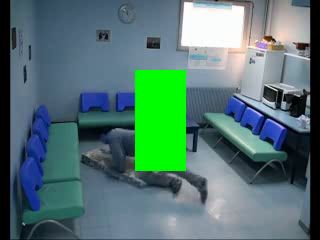

In [ ]:
#showing one frame of video sample
from google.colab.patches import cv2_imshow
cv2_imshow(videosample[0][60].numpy())  #showing frame 60 from first dimension

In [ ]:
#shape in tasvir ya frame
videosample[0][20].shape

torch.Size([240, 320, 3])

# **Video Custom Dataset**

# **Transform**

In [ ]:
from torchvision.transforms import ColorJitter, RandomRotation

In [ ]:
#changing the positions
class ConvertBCHWtoCBHW(nn.Module):
    """Convert tensor from (B, H, W, C) to (B, C, H, W)"""

    def forward(self, vid: torch.Tensor) -> torch.Tensor:
        #return vid.permute(3, 0, 1, 2)
        return vid.permute(0, 3, 1, 2)


class CustomTransform:
    def __init__(self):
        self.convert_bchw_to_cbhw = ConvertBCHWtoCBHW()
        self.to_pil_image = transforms.ToPILImage()
        self.resize = transforms.Resize((299, 299))   #299 bud ghablan
        self.to_tensor = transforms.ToTensor()

    def __call__(self, video):
        video = self.convert_bchw_to_cbhw(video)
        video_frames_pil = [self.to_pil_image(frame) for frame in video]
        video_frames_resized = [self.resize(frame) for frame in video_frames_pil]
        video_frames_tensor = [self.to_tensor(frame) for frame in video_frames_resized]
        video = torch.stack(video_frames_tensor)
        return video

custom_transform = CustomTransform()

video_transform3 = transforms.Compose([
    custom_transform,
])


In [ ]:
#Custom video dataset class

class CustomVideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mode='train', transform=video_transform3):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        # Determine the correct label file based on the mode
        label_file = 'labels_train.csv' if mode == 'train' else 'labels_test.csv'
        self.label_file = os.path.join(root_dir, mode, label_file)

        self.video_dir = os.path.join(root_dir, mode, 'video')

        # Read the labels CSV file
        self.labels_df = pd.read_csv(self.label_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        video_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]

        video_path = os.path.join(self.video_dir, video_name) + '.mp4'

        # Load video using torchvision.io.read_video
        video, audio, info = read_video(video_path, pts_unit='sec')

        # Apply transformations if specified
        if self.transform:
            video = self.transform(video)

        # For compatibility with KineticsWithVideoId, return audio and video_idx as well
        return video, label, #idx

In [ ]:
video_train = CustomVideoDataset(root_dir='/content/drive/MyDrive/Falldetection/dataset/uplast30om', mode='train', transform=video_transform3)
video_test = CustomVideoDataset(root_dir='/content/drive/MyDrive/Falldetection/dataset/3030/uptest30', mode='test', transform=video_transform3)

In [ ]:
print(len(video_train))
print(len(video_test))

60
70


In [ ]:
video , label = video_train[10]
print(video.shape)
print(video[0].shape)   #shape frame 1
video[2].shape         #shape frame74
label

torch.Size([60, 3, 299, 299])
torch.Size([3, 299, 299])


1

# **Video DataLoder**

In [ ]:
#ok
def custom_collate_fn(batch):
    # Filter out None values (if any)
    batch = list(filter(lambda x: x is not None, batch))

    # Check if the batch is not empty
    if len(batch) > 0:
        # Get the maximum number of frames in the batch
        max_frames = max([x.shape[0] for x, _ in batch])

        # Pad frames with zero tensors to make them equal length
        padded_batch = []
        for video, label in batch:
            num_frames = video.shape[0]
            padding = torch.zeros(max_frames - num_frames, *video.shape[1:], dtype=video.dtype, device=video.device)
            padded_video = torch.cat([video, padding])
            padded_batch.append((padded_video, label))

        # Stack the padded tensors
        videos, labels = zip(*padded_batch)
        videos = torch.stack(videos)

        # Convert labels to tensor and reshape them
        labels = torch.tensor(labels, dtype=torch.float32, device=videos.device).unsqueeze(1)

        return videos, labels
    else:
        return None

In [ ]:
train_loader_video = DataLoader(video_train, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

test_loader_video = DataLoader(video_test, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

In [ ]:
a, b = next(iter(train_loader_video))   #firt N: batch size,,, second: number of images, thirs: num channels,,, 2 lasts are size of images
print(a.shape)
print(b.shape)
b

torch.Size([2, 120, 3, 299, 299])
torch.Size([2, 1])


tensor([[0.],
        [1.]])

In [ ]:
a, b = next(iter(train_loader_video))
a.shape, b.shape

(torch.Size([2, 90, 3, 299, 299]), torch.Size([2, 1]))

# **Model 1 Video (inception+LSTM) without attention**

In [ ]:
class VideoModel1(nn.Module):
    def __init__(self, num_classes=1, hidden_size=128, num_layers=1):
        super(VideoModel1, self).__init__()
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Load pre-trained DenseNet model
        self.basemodel = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights=True)
        num_features = self.basemodel.fc.in_features
        self.basemodel.fc = nn.Identity()  # Remove the classification layer

        # LSTM layer
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, batch_first=True)

        # Fully connected layers
        self.fc2 = nn.Linear(hidden_size, num_classes)

        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Send input data to the same device as the model parameters
        x = x.to(next(self.parameters()).device)

        # Reshape input tensor
        batch_size, frames, channels, height, width = x.size()
        x = x.view(batch_size * frames, channels, height, width)

        # CNN feature extraction
        with torch.no_grad():
            inception_output = self.basemodel(x)
            if self.training:
                features = inception_output.logits
                # Reshape features tensor
                features = features.view(batch_size, frames, -1)
            else:
                features = inception_output.view(batch_size, frames, -1)

        # LSTM temporal modeling
        x, (hn, _) = self.rnn(features)

        # Final classification
        hn = hn[-1]  # Select the output of the last LSTM cell
        output = self.fc2(hn)

        # Apply sigmoid activation
        output = self.sigmoid(output)

        return output



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model1 = VideoModel1()
model1.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 184MB/s] 


VideoModel1(
  (basemodel): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): B

In [ ]:
#test model with random numbers
z = torch.randn(2, 128, 3, 299, 299)

In [ ]:
model1(z).shape

torch.Size([2, 1])

In [ ]:
model1(a).shape

torch.Size([2, 1])

In [ ]:
import torchvision

# **Training Video Model**

In [ ]:
# loss_fn = nn.BCELoss()
# optimizer = optim.Adam(model1.parameters(), lr=0.0001)

In [ ]:
x_batch, y_batch = next(iter(train_loader_video))
outputs = model1(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.8972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


# **checking the best learning rate**

In [ ]:
num_epochs = 5
for lr in [0.9, 0.5, 0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = VideoModel1()
  model.to(device)
  #model = torch.load('model.pt')
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader_video, loss_fn, optimizer, epoch)
  print()

LR=0.9


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 4: 100%|██████████| 65/65 [01:19<00:00,  1.23s/batch, accuracy=76.2, loss=23.8]



LR=0.5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 4: 100%|██████████| 65/65 [01:17<00:00,  1.20s/batch, accuracy=76.2, loss=23.8]



LR=0.1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 4: 100%|██████████| 65/65 [01:18<00:00,  1.20s/batch, accuracy=65.4, loss=0.922]



LR=0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 4: 100%|██████████| 65/65 [01:18<00:00,  1.21s/batch, accuracy=70, loss=0.589]



LR=0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 4: 100%|██████████| 65/65 [01:18<00:00,  1.22s/batch, accuracy=76.2, loss=0.526]



LR=0.0001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 4: 100%|██████████| 65/65 [01:18<00:00,  1.21s/batch, accuracy=76.2, loss=0.484]


In [ ]:
num_epochs = 10
for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = VideoModel1()
  model.to(device)
  #model = torch.load('model.pt')
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader_video, loss_fn, optimizer, epoch)
  print()

LR=0.1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 9: 100%|██████████| 65/65 [01:17<00:00,  1.19s/batch, accuracy=70.8, loss=0.889]



LR=0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 9: 100%|██████████| 65/65 [01:17<00:00,  1.19s/batch, accuracy=76.2, loss=0.562]



LR=0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 9: 100%|██████████| 65/65 [01:17<00:00,  1.20s/batch, accuracy=77.7, loss=0.468]



LR=0.0001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 9: 100%|██████████| 65/65 [01:16<00:00,  1.18s/batch, accuracy=81.5, loss=0.43]


In [ ]:
num_epochs = 20
for lr in [0.001, 0.0001]:
  print(f'LR={lr}')
  model = VideoModel1()
  model.to(device)
  #model = torch.load('model.pt')
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader_video, loss_fn, optimizer, epoch)
  print()

LR=0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 19: 100%|██████████| 65/65 [01:18<00:00,  1.20s/batch, accuracy=81.5, loss=0.367]



LR=0.0001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 19: 100%|██████████| 65/65 [01:19<00:00,  1.23s/batch, accuracy=90, loss=0.284]


# **Step 1: forward path**

In [ ]:
x_batch, y_batch = next(iter(train_loader_video))
outputs = model1(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.6548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


# **Step 2: backward path**

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
  videomodel, _, _ = train_one_epoch(model1, train_loader_video, loss_fn, optimizer, epoch)

Epoch 0:  30%|███       | 9/30 [00:28<01:03,  3.04s/batch, accuracy=61.1, loss=0.615]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 0: 100%|██████████| 30/30 [01:29<00:00,  2.98s/batch, accuracy=58.3, loss=0.628]


# **Step 3 : training more epochs, finall step**

In [ ]:
# lr = 0.0001
# wd = 1e-4

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model1,
                                                 train_loader_video,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model1,
                                     test_loader_video,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'modelrec.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()


# **Multimodal (Audio+Video)**

# **cheking the output shape of models**

# **shape of M5 model output (audio)**

In [ ]:
# Generate random input for the audio model
audio_input = torch.randn(2, 1, 16000)  # Assuming 2 samples, 1 channel, 16000 audio features

# Create an instance of the M5 audio model
audio_model = M5()

# Remove the last fully connected layer (fc1) from the audio model
audio_model.fc1 = nn.Identity()

# Pass the random input through the audio model
audio_output = audio_model(audio_input)

# Print the shape of the audio output
print("Audio output shape before fc1:", audio_output.shape)

Audio output shape before fc1: torch.Size([2, 64])


# **shape of Video Model output**

In [ ]:
# Generate random input for the video model
video_input = torch.randn(2, 10, 3, 299, 299)  # Assuming 2 samples, 10 frames, 3 channels, 224x224 video frames

# Create an instance of the VideoModel
video_model = VideoModel1()

# Remove the second fully connected layer (fc2) from the video model
video_model.fc2 = nn.Identity()

# Adjust the input size for the convolutional layers
video_model.basemodel = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
video_model.basemodel.fc = nn.Identity()  # Remove the classification layer

# Pass the random input through the video model
video_output = video_model(video_input)

# Print the shape of the video output
print("Video output shape before fc2:", video_output.shape)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Video output shape before fc2: torch.Size([2, 128])


# **MultiModal**

**mid level fusion multimodal**

In [ ]:
# Define the combined multimodal model with mid-level fusion
class MidLevelFusionModel(nn.Module):
    def __init__(self, audio_model, video_model):
        super(MidLevelFusionModel, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model
        self.fc = nn.Linear(audio_model.fc1.out_features + video_model.fc2.out_features, 1)  # Output size for binary classification

    def forward(self, audio_input, video_input):
        with torch.no_grad():
            # Pass audio input through audio model
            audio_features = self.audio_model(audio_input)

            # Pass video input through video model
            video_features = self.video_model(video_input)

        # Concatenate audio and video features
        combined_features = torch.cat((audio_features, video_features), dim=1)

        # Pass combined features through fully connected layer
        output = self.fc(combined_features)

        return torch.sigmoid(output)

In [ ]:
#loading weights of trained model
audio_model = torch.load('/content/drive/MyDrive/Falldetection/models/modelaudio.pt')
video_model = torch.load('/content/drive/MyDrive/Falldetection/models/modelvideo.pt')

In [ ]:
# # Instantiate audio and video models
# audio_model = M5(n_input=1, n_output=1)
# video_model = VideoModel1()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
audio_model.to(device)
video_model.to(device)


VideoModel1(
  (basemodel): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): B

In [ ]:
# Instantiate the multimodal model with mid-level fusion
mid_level_fusion_model = MidLevelFusionModel(audio_model, video_model)
mid_level_fusion_model.to(device)

MidLevelFusionModel(
  (audio_model): M5(
    (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(mid_level_fusion_model.parameters(), lr=0.01)

**calculatin all metrics**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    tp, fp, tn, fn = 0, 0, 0, 0  # Initialize true positive, false positive, true negative, false negative

    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = mid_level_fusion_model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Calculate true positive, false positive, true negative, false negative
        tp += ((predicted == 1) & (audio_labels == 1)).sum().item()
        fp += ((predicted == 1) & (audio_labels == 0)).sum().item()
        tn += ((predicted == 0) & (audio_labels == 0)).sum().item()
        fn += ((predicted == 0) & (audio_labels == 1)).sum().item()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Calculate Sensitivity, Specificity, Precision, and F1-score
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}')

**Calculating only accyracy and loss**

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = mid_level_fusion_model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%')

**accuray and sensivity**

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    true_positives = 0
    false_negatives = 0

    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = mid_level_fusion_model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Calculate true positives and false negatives
        true_positives += ((predicted == 1) & (audio_labels == 1)).sum().item()
        false_negatives += ((predicted == 0) & (audio_labels == 1)).sum().item()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate sensitivity for the epoch
    sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%, Sensitivity: {sensitivity:.2f}')

In [ ]:
# Save the model's state dictionary (weights of multimodal)
torch.save(mid_level_fusion_model.state_dict(), 'mid_level_fusion_model_weightsrec.pth')

In [ ]:
#save entire model (model va weights)
torch.save(mid_level_fusion_model, 'mid_level_fusion_model_full_updatasett.pth')


In [ ]:
# #Loading the multimodal model
# # Load the entire model
# loaded_model = torch.load('mid_level_fusion_model.pth')

# # Load the state dictionary and create the model instance with the same architecture
# loaded_model = MidLevelFusionModel(audio_model, video_model)
# loaded_model.load_state_dict(torch.load('mid_level_fusion_model_state.pth'))

**Testing Loop Multimodal**

In [ ]:
# Load the saved model
model = torch.load('/content/mid_level_fusion_model_full.pth')

# Set the model to evaluation mode
model.eval()

num_epochs = 15
# Testing loop
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(test_dataloader_audio, test_loader_video), total=len(test_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(audio_inputs, video_inputs)
        #loss = criterion(outputs, audio_labels.float())

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        #total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%')

**test with sensivity**

In [ ]:
# Load the saved model
model = torch.load('/content/mid_level_fusion_model_full_7_second.pth')

# Set the model to evaluation mode
model.eval()

num_epochs = 15
# Testing loop
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    true_positives = 0
    false_negatives = 0

    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(test_dataloader_audio, test_loader_video), total=len(test_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Calculate true positives and false negatives
        true_positives += ((predicted == 1) & (audio_labels == 1)).sum().item()
        false_negatives += ((predicted == 0) & (audio_labels == 1)).sum().item()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate sensitivity for the epoch
    sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(test_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%, Sensitivity: {sensitivity:.2f}')

**all metrics in test**

In [ ]:
# Load the saved model
model = torch.load('/content/mid_level_fusion_model_full_salt2.pth')

# Set the model to evaluation mode
model.eval()

num_epochs = 15
# Testing loop
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    true_positives = 0
    false_negatives = 0
    true_negatives = 0
    false_positives = 0

    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(test_dataloader_audio, test_loader_video), total=len(test_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Calculate true positives, false negatives, true negatives, and false positives
        true_positives += ((predicted == 1) & (audio_labels == 1)).sum().item()
        false_negatives += ((predicted == 0) & (audio_labels == 1)).sum().item()
        true_negatives += ((predicted == 0) & (audio_labels == 0)).sum().item()
        false_positives += ((predicted == 1) & (audio_labels == 0)).sum().item()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate metrics for the epoch
    sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(test_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Precision: {precision:.2f}, F1-score: {f1_score:.2f}')

**Accuracy on test dataset**

In [ ]:
# Load the saved model
model = torch.load('/content/mid_level_fusion_model_full_salt2.pth')

# Set the model to evaluation mode
model.eval()

num_epochs = 50
# Testing loop
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(test_dataloader_audio, test_loader_video), total=len(test_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(test_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%')



In [ ]:
model4 = torch.load('/content/mid_level_fusion_model_full_salt7.pth')

In [ ]:
# Inspect the model parameters
for name, param in model4.named_parameters():
    print(name, param)

In [ ]:
num_params(model4)

26.252237

# **Test and train together**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), inputs.size(0))
        acc_meter.update(binary_accuracy(outputs, targets), inputs.size(0))

    return loss_meter.avg, acc_meter.avg

def validation(model, val_loader, loss_fn):
    model.eval()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss_meter.update(loss.item(), inputs.size(0))
            acc_meter.update(binary_accuracy(outputs, targets), inputs.size(0))

    return loss_meter.avg, acc_meter.avg

In [ ]:
# Initialize lists to store loss and accuracy history
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

In [ ]:
best_val_loss = float('inf')

num_epochs = 100

In [ ]:
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(mid_level_fusion_model, train_dataloader_audio, criterion, optimizer, epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Validate
    val_loss, val_acc = validation(mid_level_fusion_model, test_dataloader_audio, criterion)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # Check if the validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(mid_level_fusion_model.state_dict(), 'best_model.pt')

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# **Decision fusion model**

**Model 1 : simple averaging**

In [ ]:
# Define the combined multimodal model with decision fusion
class DecisionFusionModel(nn.Module):
    def __init__(self, audio_model, video_model):
        super(DecisionFusionModel, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model

    def forward(self, audio_input, video_input):
        # Pass audio input through audio model
        audio_output = self.audio_model(audio_input)

        # Pass video input through video model
        video_output = self.video_model(video_input)

        # Combine audio and video outputs (e.g., weighted voting, averaging, etc.)
        combined_output = (audio_output + video_output) / 2  # Example: simple averaging

        return combined_output

In [ ]:
# Instantiate the multimodal model with decision fusion
decision_fusion_model = DecisionFusionModel(audio_model, video_model)

In [ ]:
decision_fusion_model.to(device)

DecisionFusionModel(
  (audio_model): M5(
    (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (

In [ ]:
# # Define loss function and optimizer
# criterion = nn.BCELoss()  # Binary cross-entropy loss
# optimizer = optim.Adam(decision_fusion_model.parameters(), lr=0.01)

In [ ]:
criterion.to(device)

BCELoss()

In [ ]:
num_epochs = 100
decision_fusion_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = decision_fusion_model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%')

**Model 2: Majority Voting**

In [ ]:
class MajorityVotingFusionModel(nn.Module):
    def __init__(self, audio_model, video_model):
        super(MajorityVotingFusionModel, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model

    def forward(self, audio_input, video_input):
        # Pass audio input through audio model
        audio_output = self.audio_model(audio_input)
        # Pass video input through video model
        video_output = self.video_model(video_input)

        # Majority voting
        combined_output = torch.round((audio_output + video_output) / 2)

        return combined_output

# Instantiate the multimodal model with decision fusion
majority_voting_model = MajorityVotingFusionModel(audio_model, video_model)
majority_voting_model.to(device)

MajorityVotingFusionModel(
  (audio_model): M5(
    (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)

In [ ]:
num_epochs = 5
decision_fusion_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass with no gradient calculation
        with torch.no_grad():
            outputs = majority_voting_model(audio_inputs, video_inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss = criterion(outputs, audio_labels.float())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%')

**Model 3: Weighted Voting**

In [ ]:
class WeightedVotingFusionModel(nn.Module):
    def __init__(self, audio_model, video_model):
        super(WeightedVotingFusionModel, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model

    def forward(self, audio_input, video_input):
        # Pass audio input through audio model
        audio_output = self.audio_model(audio_input)

        # Pass video input through video model
        video_output = self.video_model(video_input)

        # Round predictions from both models
        audio_pred = torch.round(audio_output)
        video_pred = torch.round(video_output)

        # Weighted voting
        combined_output = torch.mode(torch.cat((audio_pred, video_pred), dim=1), dim=1).values

        return combined_output

**Model 4 : weighted averaging**

In [ ]:
class WeightedAveragingFusionModel(nn.Module):
    def __init__(self, audio_model, video_model, audio_weight=0.5, video_weight=0.5):
        super(WeightedAveragingFusionModel, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model
        self.audio_weight = audio_weight
        self.video_weight = video_weight

    def forward(self, audio_input, video_input):
        # Pass audio input through audio model
        audio_output = self.audio_model(audio_input)

        # Pass video input through video model
        video_output = self.video_model(video_input)

        # Weighted averaging
        combined_output = self.audio_weight * audio_output + self.video_weight * video_output

        return combined_output

In [ ]:
# Instantiate the multimodal model with decision fusion
weightedaverage_model = WeightedAveragingFusionModel(audio_model, video_model)
weightedaverage_model.to(device)

WeightedAveragingFusionModel(
  (audio_model): M5(
    (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=Fal

In [ ]:
# criterion = nn.BCELoss()  # Binary cross-entropy loss
# optimizer = optim.Adam(weightedaverage_model.parameters(), lr=0.01)

In [ ]:
num_epochs = 100
weightedaverage_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = weightedaverage_model(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%')

# **D-S theory**

In [ ]:
class MidLevelFusionModel2(nn.Module):
    def __init__(self, audio_model, video_model):
        super(MidLevelFusionModel2, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model
        self.fc = nn.Linear(audio_model.fc1.out_features + video_model.fc2.out_features, 1)  # Output size for binary classification

    def forward(self, audio_input, video_input):
        with torch.no_grad():
            # Pass audio input through audio model
            audio_features = self.audio_model(audio_input)

            # Pass video input through video model
            video_features = self.video_model(video_input)

        # Concatenate audio and video features
        combined_features = torch.cat((audio_features, video_features), dim=1)

        # Pass combined features through fully connected layer
        output = self.fc(combined_features)

        return torch.sigmoid(output)

In [ ]:
# Load trained models
audio_model = torch.load('/content/drive/MyDrive/Falldetection/models/modelaudio.pt')
video_model = torch.load('/content/drive/MyDrive/Falldetection/models/modelsalt7.pt')

In [ ]:
audio_model.to(device)
video_model.to(device)

mid_level_fusion_model2 = MidLevelFusionModel2(audio_model, video_model)
mid_level_fusion_model2.to(device)

MidLevelFusionModel2(
  (audio_model): M5(
    (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    

In [ ]:
# criterion = nn.BCELoss()  # Binary cross-entropy loss
# optimizer = optim.Adam(mid_level_fusion_model.parameters(), lr=0.1)

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for (audio_data, audio_labels), (video_data, video_labels) in tqdm(zip(train_dataloader_audio, train_loader_video), total=len(train_dataloader_audio)):
        # Move input data to GPU
        audio_inputs, audio_labels = audio_data.to(device), audio_labels.to(device)
        video_inputs, video_labels = video_data.to(device), video_labels.to(device)

        # Forward pass
        outputs = mid_level_fusion_model2(audio_inputs, video_inputs)
        loss = criterion(outputs, audio_labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        correct += (predicted == audio_labels).sum().item()
        total += audio_labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

    # Calculate accuracy for the epoch
    accuracy = 100 * correct / total

    # Implement Dempster-Shafer theory here
    # 1. Obtain predictions from each modality
    audio_predictions = audio_model(audio_inputs)
    video_predictions = video_model(video_inputs)

    # 2. Convert predictions to belief functions
    audio_belief = torch.softmax(audio_predictions, dim=1)
    video_belief = torch.softmax(video_predictions, dim=1)

    # 3. Combine belief functions using Dempster's rule
    combined_belief = audio_belief * video_belief

    # 4. Make a decision based on the combined belief function
    final_decision = torch.argmax(combined_belief, dim=1)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_dataloader_audio):.4f}, Accuracy: {accuracy:.2f}%')